#Importing packages

- keras
- cv2
-sklearn

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf
import imghdr
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle 
from sklearn.model_selection import KFold

Create classes and set the image size

In [9]:
class_names = ['Dogs', 'Cats']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

Create the function to load the images, setting the color format and the size.

In [10]:
def load_data():
    
    datasets = ['C:/Users/simon/Desktop/CatsDogsSeparate/test', 'C:/Users/simon/Desktop/CatsDogsSeparate/train']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

Load and split the images into training (90%) and test (10%) sets 

In [11]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  0%|          | 1/1385 [00:00<02:42,  8.50it/s]

Loading C:/Users/simon/Desktop/CatsDogsSeparate/test


100%|██████████| 1410/1410 [00:18<00:00, 78.24it/s] 


Loading C:/Users/simon/Desktop/CatsDogsSeparate/train


100%|██████████| 11022/11022 [02:11<00:00, 83.74it/s] 


The following function will allow to shuffle arrays in a consistent way. 
It required as input the arrays (the training images and labels in this case), the random state (which determine random number generation for shuffling the data) and the number of sample to generate.

In [12]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [14]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 2795
Number of testing examples: 22075
Each image is of size: (150, 150)


Visualise the compositions of our sets

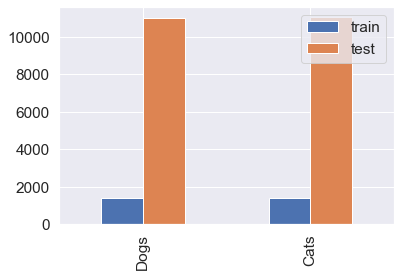

In [15]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

Normalize the sets to a proper use in in the neaural network

In [16]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

Display an image 

In [18]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

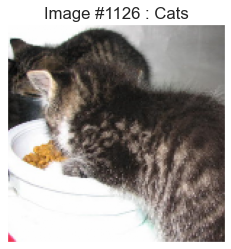

In [19]:
display_random_image(class_names, train_images, train_labels)

Display various images

In [20]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

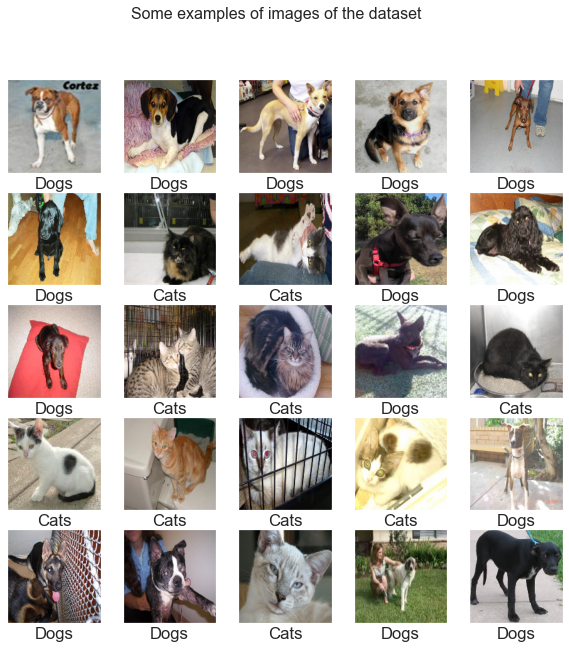

In [21]:
display_examples(class_names, train_images, train_labels)

Create a model

- Sequential: it is one of the model that is used to investigate varied types of neural networks where the model gets in one input as feedback and expects an output as desired. Keras class is one of the important class as part of the entire Keras sequential model. This class helps in creating a cluster where a cluster is formed with layers of information or data that flows with top to bottom approach having a lot of layers incorporated with tf.Keras. a model where most of its features are trained with algorithms that provide a lot of sequence to the model.
- COnv2D>This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.
    - activation: specify the activation funtion for the layer. Relu Applies the rectified linear unit activation function. Other functions are sigmoid, softmax, softplus, softsign and more.
- MaxPooling2D: Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.
- Flatten: Return a copy of the array collapsed into one dimension.
- Dense: Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). These are all attributes of Dense. 

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

config the model with losses and metrics with model.compile()

- optimizer: String (name of optimizer) or optimizer instance. E.g.: Adam, Adamax, Adagrad, FTRL, RMSprop. SGD.
    Adam is suggested as computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters
- loss: Loss function. May be a string (name of loss function), or a tf.keras.losses.Loss instance. sparse_categorical_crossentropy  Computes the cross-entropy loss between true labels and predicted labels. cross-entropy loss for binary (0 or 1) classification applications. The loss function requires the following inputs:
    y_true (true label): This is either 0 or 1.
    y_pred (predicted value): This is the model's prediction
- metrics: List of metrics to be evaluated by the model during training and testing.

In [23]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Fit train the model for a fixed number of epochs (which are the iteration in the dataset).
The batch are the number of samples per gradient update. 
val_loss is the value of cost function for your cross-validation data and loss is the value of cost function for your training data. On validation data, neurons using drop out do not drop random neurons. The reason is that during training we use drop out in order to add some noise for avoiding over-fitting. During calculating cross-validation, we are in the recall phase and not in the training phase. We use all the capabilities of the network.

In [24]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
18/18 [==============================] - 68s 3s/step - loss: 1.0750 - accuracy: 0.4875 - val_loss: 0.7686 - val_accuracy: 0.4776
Epoch 2/20
18/18 [==============================] - 47s 3s/step - loss: 0.6671 - accuracy: 0.6064 - val_loss: 0.6686 - val_accuracy: 0.5796
Epoch 3/20
18/18 [==============================] - 47s 3s/step - loss: 0.6245 - accuracy: 0.6543 - val_loss: 0.6546 - val_accuracy: 0.6136
Epoch 4/20
18/18 [==============================] - 48s 3s/step - loss: 0.5781 - accuracy: 0.6968 - val_loss: 0.6104 - val_accuracy: 0.6583
Epoch 5/20
18/18 [==============================] - 49s 3s/step - loss: 0.5543 - accuracy: 0.7165 - val_loss: 0.6189 - val_accuracy: 0.6673
Epoch 6/20
18/18 [==============================] - 46s 3s/step - loss: 0.4542 - accuracy: 0.8041 - val_loss: 0.5918 - val_accuracy: 0.6869
Epoch 7/20
18/18 [==============================] - 47s 3s/step - loss: 0.4062 - accuracy: 0.8193 - val_loss: 0.5840 - val_accuracy: 0.7120
Epoch 8/20
18/18 [==

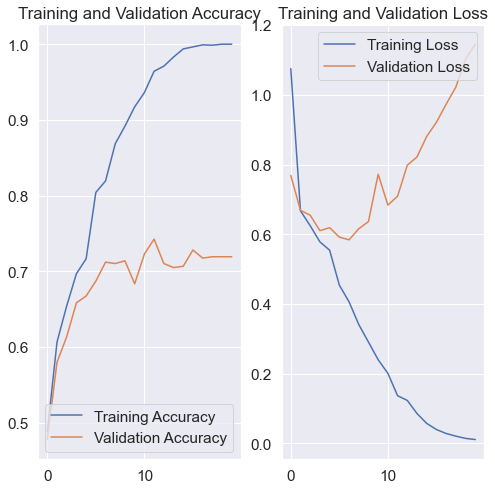

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Returns the loss value & metrics values for the model in test mode.

In [32]:
test_loss = model.evaluate(test_images, test_labels)
print(f'Test loss: {test_loss[0]} / Test accuracy: {test_loss[1]}')

690/690 [==============================] - 141s 193ms/step - loss: 1.2465 - accuracy: 0.6978
Test loss: 1.2465399503707886 / Test accuracy: 0.6978482604026794


Generates output predictions for the input samples.

Computation is done in batches. This method is designed for batch processing of large numbers of inputs. It is not intended for use inside of loops that iterate over your data and process small numbers of inputs at a time.

690/690 [==============================] - 137s 183ms/step


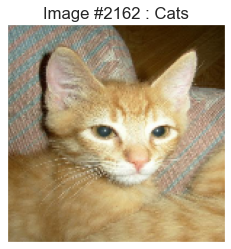

In [28]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [29]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

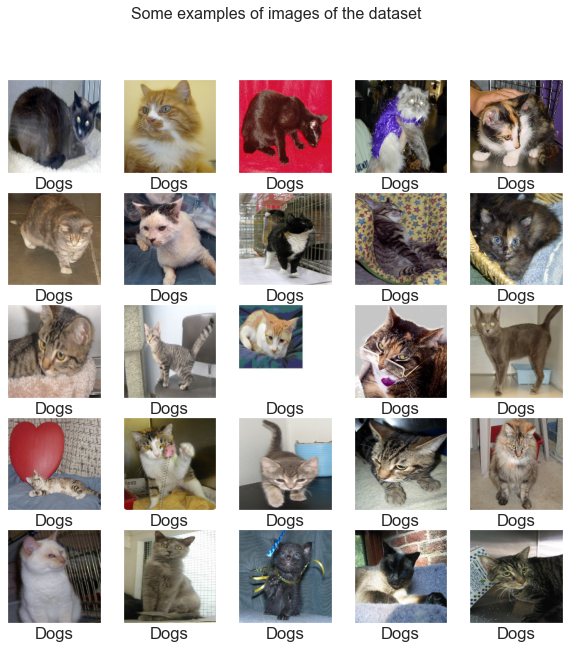

In [30]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

Check the misclassification against the correct ones

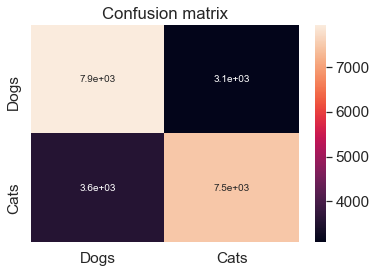

In [31]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [3]:
class_names = ['Dogs', 'Cats']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

def load_images():
    
    dts = ['C:/Users/simon/Desktop/CatsDogsSeparateCV/train',
    'C:/Users/simon/Desktop/CatsDogsSeparateCV/test']
    result = []
    
    for dt in dts:
        
        imgs,labels = [], []
        
        print("Loading {}".format(dt))
        
        for folder in os.listdir(dt):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dt, folder))):
                
                img_path = os.path.join(os.path.join(dt, folder), file)
                
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMAGE_SIZE) 
                
                imgs.append(img)
                labels.append(label)
                
        imgs, labels = np.array(imgs, dtype = 'float32'), np.array(labels, dtype = 'int32')
        
        result.append((img, labels))

    return result

(train_imgs, train_labels), (test_imgs, test_labels) = load_images()

  1%|          | 24/2631 [00:00<00:10, 238.26it/s]

Loading C:/Users/simon/Desktop/CatsDogsSeparateCV/train


  5%|▍         | 26/540 [00:00<00:02, 245.94it/s]

Loading C:/Users/simon/Desktop/CatsDogsSeparateCV/test


100%|██████████| 996/996 [00:03<00:00, 305.86it/s]


In [5]:
folds = 5

accuracy_per_fold = []
loss_per_fold = []

inputs = np.concatenate((train_imgs, test_imgs), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

kfold = KFold(n_splits=folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(train_imgs, train_labels):
  model = Sequential()
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150,150,3)))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])


  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=50,
              epochs=25,
              verbose=1)

  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  accuracy_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

ValueError: Found input variables with inconsistent numbers of samples: [150, 4737]